In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL
from tensorflow.keras import layers
import time
from datetime import timedelta

from IPython import display

TensorFlow 2.x selected.


In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

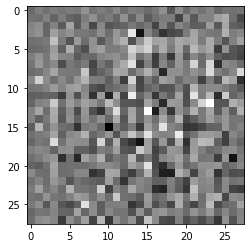

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision.numpy())

[[0.00051015]]


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [0]:
def train(dataset, epochs):
  if not os.path.exists('./generator'):
    os.mkdir('./generator')
  if not os.path.exists('./discriminator'):
    os.mkdir('./discriminator')
  generate_and_save_images(generator, 0, seed, save_img=True)
  
  gen_losses = []
  disc_losses = []
  start_training = time.perf_counter()

  for epoch in range(1, epochs + 1):
    gen_loss = tf.keras.metrics.Mean()
    disc_loss = tf.keras.metrics.Mean()

    start = time.time()
    for image_batch in dataset:
      gl, dl = train_step(image_batch)
      gen_loss(gl)
      disc_loss(dl)
    elapsed = time.time() - start

    gen_losses.append(gen_loss.result())
    disc_losses.append(disc_loss.result())

    display.clear_output(wait=True)
    print (f'ETA: {timedelta(seconds=int(elapsed * (epochs - epoch)))}\tEpoch: {epoch}/{epochs}\tGenerator Loss: {gen_losses[-1]:.4f}\tDiscriminator Loss: {disc_losses[-1]:.4f}')
    generate_and_save_images(generator, epoch, seed, epoch % 5 == 0)

    if epoch % 5 == 0:
      generator.save_weights(f'./generator/generator-{epoch:04d}.h5')
      discriminator.save_weights(f'./discriminator/discriminator-{epoch:04d}.h5')

  training_time = time.perf_counter() - start_training

  return gen_losses, disc_losses, training_time

In [0]:
def generate_and_save_images(model, epoch, test_input, save_img=False):
  if not os.path.exists('./samples'):
    os.mkdir('./samples')
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if save_img:
    plt.savefig('samples/sample_{:04d}.png'.format(epoch))
  plt.show()

ETA: 0:00:00	Epoch: 500/500	Generator Loss: 0.9023	Discriminator Loss: 1.2690


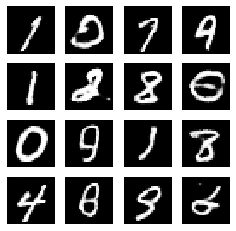

In [18]:
gen_losses, disc_losses, training_time = train(train_dataset, EPOCHS)

In [19]:
print(f'Training Time: {timedelta(seconds=int(training_time))}')

Training Time: 1:35:46


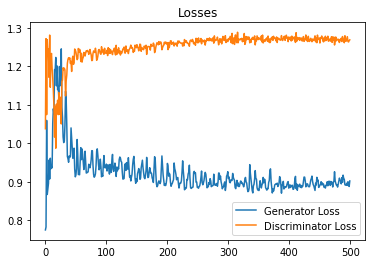

In [20]:
plt.plot(list(range(len(gen_losses))), gen_losses, label='Generator Loss')
plt.plot(list(range(len(disc_losses))), disc_losses, label='Discriminator Loss')
plt.title('Losses')
plt.legend()

plt.savefig('dcgan-losses.png')
plt.show()

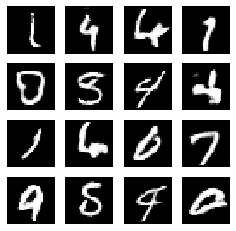

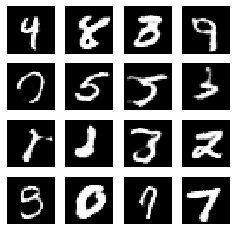

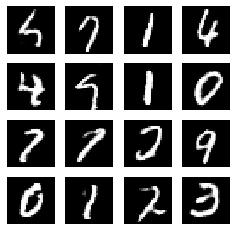

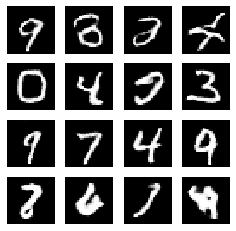

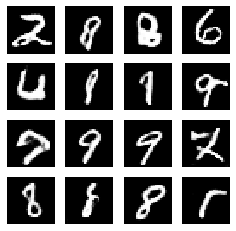

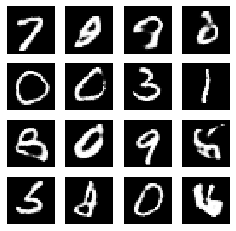

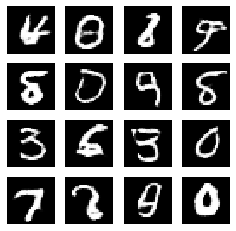

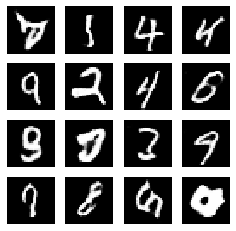

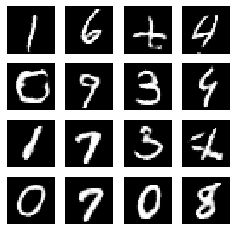

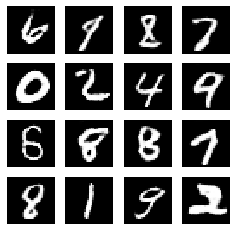

In [22]:
for j in range(10):
  seed = tf.random.normal([num_examples_to_generate, noise_dim])
  generate_and_save_images(generator, j, seed, True)

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('images/image_at_epoch_{:04d}.png'.format(epoch_no))

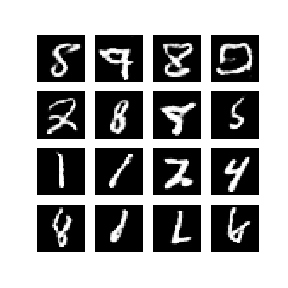

In [0]:
display_image(EPOCHS)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    # frame = 2*(i**0.5)
    # if round(frame) > round(last):
    #   last = frame
    # else:
    #   continue
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [24]:
shutil.make_archive('dcgan-outputs', 'zip', 'images')
shutil.make_archive('dcgan-samples', 'zip', 'samples')
shutil.make_archive('dcgan-generator', 'zip', 'generator')
shutil.make_archive('dcgan-discriminator', 'zip', 'discriminator')
# shutil.make_archive('dcgam-training-checkpoints', 'zip', 'training_checkpoints')
# generator.save_weights('dcgan-generator.h5')
# discriminator.save_weights('dcgan-discriminator.h5')

'/content/dcgan-discriminator.zip'